In [1]:
from fastai.vision.all import *

In [2]:
import os
import numpy as np
from lxml import etree

In [3]:
path = Path('data/plasmodium-phonecamera/')
path.ls()

(#2365) [Path('data/plasmodium-phonecamera/plasmodium-phone-0487.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0068.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0114.xml'),Path('data/plasmodium-phonecamera/plasmodium-phone-0595.xml'),Path('data/plasmodium-phonecamera/plasmodium-phone-0085.xml'),Path('data/plasmodium-phonecamera/plasmodium-phone-0519.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-1116.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-1011.xml'),Path('data/plasmodium-phonecamera/plasmodium-phone-0930.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0091.xml')...]

In [4]:
img_files = get_image_files(path)
img_files

(#1182) [Path('data/plasmodium-phonecamera/plasmodium-phone-0487.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0068.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0519.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-1116.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0930.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0379.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0054.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0243.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-0667.jpg'),Path('data/plasmodium-phonecamera/plasmodium-phone-1110.jpg')...]

In [5]:
def get_annotations_for_single_image(filename, objectclass=None):
    '''
    Given an annotation XML filename, get a list of the bounding boxes around
    each object (the ground truth object locations).
    '''
    annofile = filename[:-3] + 'xml'
    file_exists = os.path.exists(annofile)
    boundingboxes = []
    labels = []

    if (file_exists):
        # Read the bounding boxes from xml annotation
        tree = etree.parse(annofile)
        r = tree.xpath('//bndbox')

        if (len(r) != 0):
            for i in range(len(r)):
                if (objectclass==None) or (objectclass in r[i].getparent().xpath('label')[0].text.lower()):
                    xmin = round(float(r[i].xpath('xmin')[0].text))
                    xmin = max(xmin,1)
                    xmax = round(float(r[i].xpath('xmax')[0].text))
                    ymin = round(float(r[i].xpath('ymin')[0].text))
                    ymin = max(ymin,1)
                    ymax = round(float(r[i].xpath('ymax')[0].text))
                    xmin, xmax, ymin, ymax = int(xmin),int(xmax),int(ymin),int(ymax)

                    boundingboxes.append([xmin,ymin,xmax,ymax])
                    labels.append(r[i].getparent().xpath('name')[0].text)

    if len(boundingboxes) == 0:
        return [], []
    
    #return np.vstack(boundingboxes)
    return boundingboxes, labels

In [6]:
def get_full_annotations(img_files):
    imgs = []
    lbl_bbox = []
    for img in img_files:
        annot = get_annotations_for_single_image(str(img))
        if not annot[0] == []:
            imgs.append(img.name)
            lbl_bbox.append(annot)
    return imgs, lbl_bbox

In [7]:
imgs, lbl_bbox = get_full_annotations(img_files)

In [8]:
len(imgs), len(lbl_bbox)

(948, 948)

In [9]:
imgs[0]

'plasmodium-phone-0487.jpg'

In [10]:
lbl_bbox[0]

([[336, 384, 376, 424],
  [489, 276, 529, 316],
  [244, 366, 284, 406],
  [190, 338, 230, 378],
  [166, 434, 206, 474],
  [213, 448, 253, 488],
  [442, 663, 482, 703],
  [683, 262, 723, 302],
  [665, 351, 705, 391],
  [597, 91, 637, 131],
  [468, 79, 509, 119],
  [369, 287, 409, 327],
  [374, 447, 414, 487],
  [563, 426, 603, 466],
  [305, 682, 345, 722],
  [153, 133, 193, 173],
  [627, 168, 667, 208],
  [70, 383, 110, 423]],
 ['plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium',
  'plasmodium'])

In [11]:
img2bbox = dict(zip(imgs, lbl_bbox))

In [12]:
getters = [lambda o: path/o, lambda o: img2bbox[o][0], lambda o: img2bbox[o][1]]

In [13]:
item_tfms = [Resize(750, method='pad'),]
batch_tfms = [Rotate(), Flip(), Dihedral(align_corners=True), Normalize.from_stats(*imagenet_stats)]

In [14]:
def get_train_imgs(noop):  return imgs

In [15]:
dblock = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 splitter=RandomSplitter(),
                 get_items=get_train_imgs,
                 getters=getters,
                 item_tfms=item_tfms,
                 batch_tfms=batch_tfms,
                 n_inp=1)

In [16]:
dls = dblock.dataloaders(path, bs=8)

In [17]:
dls.c = 1

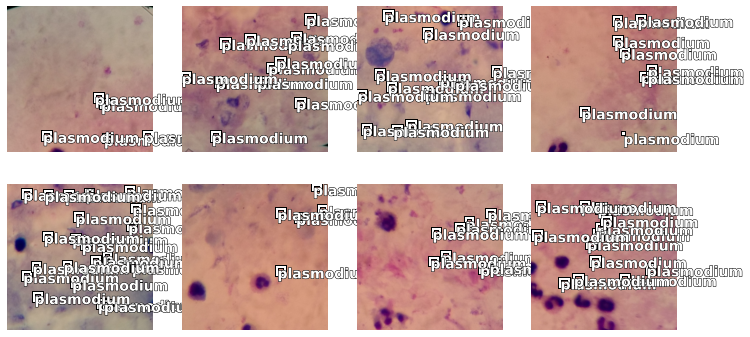

In [18]:
dls.show_batch()

## Model

In [19]:
class RelativeSelfAttention(Module):
    def __init__(self, d_in, d_out, ks, groups, stride=1):
        self.n_c, self.ks, self.groups, self.stride = d_out, ks, groups, stride
        # linear transformation for queries, values and keys
        self.qx, self.kx, self.vx = [ConvLayer(d_in, d_out, ks=1, norm_type=None,
                                               act_cls=None) for _ in range(3)]
        # positional embeddings
        self.row_embeddings = nn.Parameter(torch.randn(d_out//2, ks))
        self.col_embeddings = nn.Parameter(torch.randn(d_out//2, ks))
        
    def calc_out_shape(self, inp_shape, pad):
        out_shape = [(sz + 2*pad - self.ks) // self.stride + 1 for sz in inp_shape]
        return out_shape
    
    def forward(self, x):
        query, keys, values = self.qx(x), self.kx(x), self.vx(x)
        
        pad = (self.ks -1) // 2
        
        # use unfold to extract the memory blocks and their associated queries
        query = F.unfold(query, kernel_size=1, stride=self.stride)
        keys = F.unfold(keys, kernel_size=self.ks, padding=pad, stride=self.stride)
        values = F.unfold(values, kernel_size=self.ks, padding=pad, stride=self.stride)
        
        
        # reshape and permute the dimensions into the appropriate format for matrix multiplication
        query = query.view(query.shape[0], self.groups, self.n_c//self.groups, -1, query.shape[-1]) # bs*G*C//G*1*N
        query = query.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * 1
        keys = keys.view(keys.shape[0], self.groups, self.n_c//self.groups, -1, keys.shape[-1]) # bs*G*C//G*ks^2*N
        keys = keys.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * ks^2
        values = values.view(values.shape[0], self.groups, self.n_c//self.groups, -1, values.shape[-1]) # bs*G*C//G*ks^2*N
        values = values.permute(0, 4, 1, 2, 3) # bs * N * G * C//G * ks^2
        
        # get positional embeddings
        row_embeddings = self.row_embeddings.unsqueeze(-1).expand(-1, -1, self.ks)
        col_embeddings = self.col_embeddings.unsqueeze(-2).expand(-1, self.ks, -1)
        
        embeddings = torch.cat((row_embeddings, col_embeddings)).view(self.groups,
                                self.n_c//self.groups, -1) # G * C//G * ks^2
        # add empty dimensions to match the shape of keys
        embeddings = embeddings[None, None, -1] # 1 * 1 * G * C//G * ks^2
        
        # compute attention map
        att_map = F.softmax(torch.matmul(query.transpose(-2,-1), keys+embeddings).contiguous(), dim=-1)
        # compute final output
        out = torch.matmul(att_map, values.transpose(-2,-1)).contiguous().permute(0, 2, 3, 4, 1)
        
        return out.view(out.shape[0], self.n_c, *self.calc_out_shape(x.shape[-2:], pad)).contiguous()

In [20]:
def resnet_stem(*sizes):
    return [
        ConvLayer(sizes[i], sizes[i+1], stride=2 if i==0 else 1)
         for i in range(len(sizes) - 1)
    ] + [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]

def bottleneck(ni, nf, stride):
    if stride==1:
        layers = [ConvLayer(ni, nf//4, ks=1),
              RelativeSelfAttention(nf//4, nf//4, ks=7, groups=8),
              ConvLayer(nf//4, nf, ks=1, act_cls=None, norm_type=NormType.BatchZero)]
    else:
        layers = [ConvLayer(ni, nf//4, ks=1),
              RelativeSelfAttention(nf//4, nf//4, ks=7, groups=8),
              nn.AvgPool2d(2, ceil_mode=True),
              ConvLayer(nf//4, nf, ks=1, act_cls=None, norm_type=NormType.BatchZero)]
    
    return nn.Sequential(*layers)

In [21]:
class ResNetBlock(Module):
    def __init__(self, ni, nf, stride, sa, expansion=1):
        self.botl = bottleneck(ni, nf, stride)
        self.idconv = noop if ni==nf else ConvLayer(ni, nf, 1, act_cls=None)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        
    def forward(self, x):
        return F.relu(self.botl(x) + self.idconv(self.pool(x)))

In [22]:
class RandHead(Module):
    def __init__(self):
        pass
        
    def forward(self, x):
        rz_shape = torch.randint(210, 224, (1,))
        pad = (224 - rz_shape).item()
        h = torch.randint(0, pad+1, (1,))
        w = torch.randint(0, pad+1, (1,))
        
        # step 1 random resize
        out = F.interpolate(x, [rz_shape]*2)
        # step 2 pad
        return F.pad(out, (h, pad-h, w, pad-w))    

In [23]:
class xResNet(nn.Sequential):
    def __init__(self, channels, n_out, blocks, sa=True, expansion=1):
        stem = resnet_stem(channels, 32, 32, 64)
        self.group_sizes = [64, 64, 128, 256, 512]
        for i in range(1, len(self.group_sizes)): 
            self.group_sizes[i] *= expansion
        groups = [self._make_group(idx, n_blocks, sa=sa if idx==0 else False) 
                      for idx, n_blocks in enumerate(blocks)]
        
        super().__init__(RandHead(), *stem, *groups)
        
    def _make_group(self, idx, n_blocks, sa):
        stride = 1 if idx==1 else 2
        ni, nf = self.group_sizes[idx], self.group_sizes[idx+1]
        return nn.Sequential(*[
            ResNetBlock(ni if i==0 else nf, nf, stride=stride if i==0 else 1,
                        sa=sa if i==n_blocks-1 else False)
             for i in range(n_blocks)
        ])

In [24]:
att_model = xResNet(3, dls.c, [2,2,2,2])

In [25]:
encoder = nn.Sequential(*list(att_model.children()))

In [26]:
%cd "Practical-Deep-Learning-for-Coders-2.0/Computer Vision"

/home/jupyter/experiments/malaria/Practical-Deep-Learning-for-Coders-2.0/Computer Vision


In [27]:
from imports import *

In [28]:
get_c(dls)

1

In [29]:
arch = RetinaNet(encoder, get_c(dls), final_bias=-4)

In [31]:
ratios = [1/2,1,2]
scales = [1,2**(1/3), 2**(2/3)]

In [32]:
crit = RetinaNetFocalLoss(scales=scales, ratios=ratios)

In [33]:
def _retinanet_split(m): 
    return L(m.encoder,nn.Sequential(m.c5top6, m.p6top7, m.merges, m.smoothers, m.classifier, m.box_regressor)).map(params)

In [34]:
%pwd

'/home/jupyter/experiments/malaria/Practical-Deep-Learning-for-Coders-2.0/Computer Vision'

In [35]:
%cd "../.."

/home/jupyter/experiments/malaria


In [36]:
learn = Learner(dls, arch, loss_func=crit, splitter=_retinanet_split)

In [37]:
learn.unfreeze()

SuggestedLRs(lr_min=1.3182566908653825e-05, lr_steep=0.0006918309954926372)

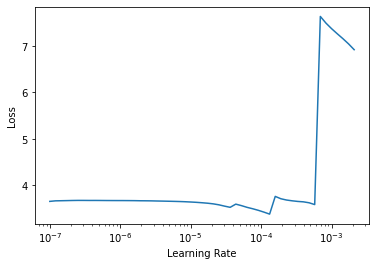

In [38]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,time
0,2.623385,1.976217,01:01
1,2.035834,1.814136,01:01
2,1.935001,1.796369,01:01
3,2.031944,1.955412,01:01
4,2.223230,1.878127,01:01
5,1.999699,1.770171,01:01
6,1.905814,1.853354,01:01
7,1.881502,1.745057,01:00
